Climate OF Scene change detection

In [1]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model = model.to(device)
model.eval()

def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image).unsqueeze(0).to(device)

def detect_scene_change(image1, image2):
    with torch.no_grad():
        input1 = preprocess_image(image1)
        input2 = preprocess_image(image2)

        output1 = model(input1)['out']
        output2 = model(input2)['out']

        output1 = output1.squeeze().cpu().numpy()
        output2 = output2.squeeze().cpu().numpy()

        change_score = np.mean(np.abs(output1 - output2))
        return change_score
    
def extract_number(text):
    match = re.search(r'\d+', text)
    if match:
        return int(match.group())
    else:
        return None

image_folder = "climate_out"
image_files = os.listdir(image_folder)
image_files.sort()  
scores = []
label_list = []
for i in range(0, len(image_files)-20, 20):  
    image_1_path = os.path.join(image_folder, image_files[i])
    image_2_path = os.path.join(image_folder, image_files[i+20])

    try:
        image_1 = Image.open(image_1_path).convert("RGB")
    except:
        print(f'{image_1_path} Open Error! Skipping to next image.')
        continue

    try:
        image_2 = Image.open(image_2_path).convert("RGB")
    except:
        print(f'{image_2_path} Open Error! Skipping to next image.')
        continue

    score = detect_scene_change(image_1, image_2)
    if score > 0.7:
        print(f'Scene change detected between {image_1_path} and {image_2_path}: {score}')
        single_score_list=[]
        image_list=[]
        for j in range(i, i + 21):
            image_1_path = os.path.join(image_folder, image_files[j])
            image_2_path = os.path.join(image_folder, image_files[j+1])

            try:
                image_1 = Image.open(image_1_path).convert("RGB")
            except:
                print(f'{image_1_path} Open Error! Skipping to next image.')
                continue

            try:
                image_2 = Image.open(image_2_path).convert("RGB")
            except:
                print(f'{image_2_path} Open Error! Skipping to next image.')
                continue
            single_score = detect_scene_change(image_1, image_2)
            image_list.append([image_1_path,image_2_path])
            single_score_list.append(single_score)

        indices = [j for j, value in enumerate(single_score_list) if value > 0.7]

        result_score = [single_score_list[index] for index in indices]
        result_image = [image_list[index] for index in indices]
        if len(result_image)==1:
            print(f'Scene change detected between {result_image[0][0]} and {result_image[0][1]}: {result_score[0]}')
            match = int(re.search(r'\d+', result_image[0][1].split('\\')[-1]).group())
            label_list.append(match)
        elif len(result_image)>1:
            for ind,ss in enumerate(result_score):
                if ss > 1:
                    print(f'Scene change detected between {result_image[ind][0]} and {result_image[ind][1]}: {ss}')
                    match = int(re.search(r'\d+', result_image[ind][1].split('\\')[-1]).group())
                    label_list.append(match)
        elif len(result_image)==0 and score <0.9:
            print(f'Scene change detected between {image_list[0][0]} to {image_list[-1][1]}: {score}')
            match1 = int(re.search(r'\d+', image_list[0][0].split('\\')[-1]).group())
            match2 = int(re.search(r'\d+', image_list[-1][1].split('\\')[-1]).group())
            label_list.append(str(match1)+"~"+str(match2))

Scene change detected between climate_out\climate_0021.jpg and climate_out\climate_0041.jpg: 0.9972837567329407
Scene change detected between climate_out\climate_0041.jpg and climate_out\climate_0061.jpg: 0.9887247681617737
Scene change detected between climate_out\climate_0061.jpg and climate_out\climate_0081.jpg: 1.0019655227661133
Scene change detected between climate_out\climate_0081.jpg and climate_out\climate_0101.jpg: 1.0885107517242432
Scene change detected between climate_out\climate_0092.jpg and climate_out\climate_0093.jpg: 1.0380715131759644
Scene change detected between climate_out\climate_0141.jpg and climate_out\climate_0161.jpg: 1.1597107648849487
Scene change detected between climate_out\climate_0156.jpg and climate_out\climate_0157.jpg: 1.1917415857315063
Scene change detected between climate_out\climate_0221.jpg and climate_out\climate_0241.jpg: 1.1908866167068481
Scene change detected between climate_out\climate_0231.jpg and climate_out\climate_0232.jpg: 1.000097870

In [2]:
shot_boundaries = []
for line in label_list:
    line = str(line)
    if '~' in line:
        start, end = map(int, line.split('~'))
        shot_boundaries.extend(list(range(start, end+1)))
    else:
        shot_boundaries.append(int(line))

num_frames = len(os.listdir(image_folder))  
det_labels = [0] * num_frames
for frame_index in shot_boundaries:
    det_labels[frame_index - 1] = 1  

print(len(det_labels))

1780


In [3]:
import os

shot_boundaries = []
with open('climate_ground.txt', 'r') as f:
    for _ in range(4):
        next(f)
    for line in f:
        line = line.strip()
        if '~' in line:
            start, end = map(int, line.split('~'))
            shot_boundaries.extend(list(range(start, end+1)))
        else:
            shot_boundaries.append(int(line))

num_frames = len(os.listdir(image_folder))  
labels = [0] * num_frames
for frame_index in shot_boundaries:
    labels[frame_index - 1] = 1  

print(len(labels))


1780


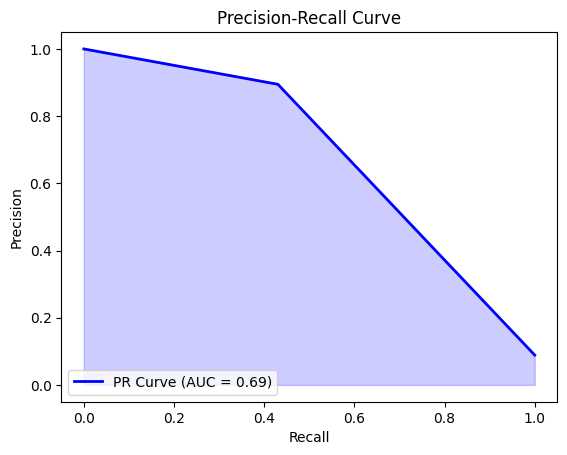

Accuracy: 0.9449438202247191
Confusion Matrix:
[[1614    8]
 [  90   68]]


In [4]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
precision, recall, _ = precision_recall_curve(labels, det_labels)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR Curve (AUC = %0.2f)' % pr_auc)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

accuracy = accuracy_score(labels, det_labels)
print("Accuracy:", accuracy)
conf_matrix = confusion_matrix(labels, det_labels)
print("Confusion Matrix:")
print(conf_matrix)

News OF Scene change detection

In [6]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model = model.to(device)
model.eval()

def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image).unsqueeze(0).to(device)

def detect_scene_change(image1, image2):
    with torch.no_grad():
        input1 = preprocess_image(image1)
        input2 = preprocess_image(image2)

        output1 = model(input1)['out']
        output2 = model(input2)['out']

        output1 = output1.squeeze().cpu().numpy()
        output2 = output2.squeeze().cpu().numpy()

        change_score = np.mean(np.abs(output1 - output2))
        return change_score
    
def extract_number(text):
    match = re.search(r'\d+', text)
    if match:
        return int(match.group())
    else:
        return None

image_folder = "news_out"
image_files = os.listdir(image_folder)
image_files.sort()  
scores = []
label_list = []
for i in range(0, len(image_files)-20, 20):  
    image_1_path = os.path.join(image_folder, image_files[i])
    image_2_path = os.path.join(image_folder, image_files[i+20])

    try:
        image_1 = Image.open(image_1_path).convert("RGB")
    except:
        print(f'{image_1_path} Open Error! Skipping to next image.')
        continue

    try:
        image_2 = Image.open(image_2_path).convert("RGB")
    except:
        print(f'{image_2_path} Open Error! Skipping to next image.')
        continue

    score = detect_scene_change(image_1, image_2)
    if score > 0.7:
        print(f'Scene change detected between {image_1_path} and {image_2_path}: {score}')
        single_score_list=[]
        image_list=[]
        for j in range(i, i + 21):
            image_1_path = os.path.join(image_folder, image_files[j])
            image_2_path = os.path.join(image_folder, image_files[j+1])

            try:
                image_1 = Image.open(image_1_path).convert("RGB")
            except:
                print(f'{image_1_path} Open Error! Skipping to next image.')
                continue

            try:
                image_2 = Image.open(image_2_path).convert("RGB")
            except:
                print(f'{image_2_path} Open Error! Skipping to next image.')
                continue
            single_score = detect_scene_change(image_1, image_2)
            image_list.append([image_1_path,image_2_path])
            single_score_list.append(single_score)

        indices = [j for j, value in enumerate(single_score_list) if value > 0.7]

        result_score = [single_score_list[index] for index in indices]
        result_image = [image_list[index] for index in indices]
        if len(result_image)==1:
            print(f'Scene change detected between {result_image[0][0]} and {result_image[0][1]}: {result_score[0]}')
            match = int(re.search(r'\d+', result_image[0][1].split('\\')[-1]).group())
            label_list.append(match)
        elif len(result_image)>1:
            for ind,ss in enumerate(result_score):
                if ss > 1:
                    print(f'Scene change detected between {result_image[ind][0]} and {result_image[ind][1]}: {ss}')
                    match = int(re.search(r'\d+', result_image[ind][1].split('\\')[-1]).group())
                    label_list.append(match)
        elif len(result_image)==0 and score <0.9:
            print(f'Scene change detected between {image_list[0][0]} to {image_list[-1][1]}: {score}')
            match1 = int(re.search(r'\d+', image_list[0][0].split('\\')[-1]).group())
            match2 = int(re.search(r'\d+', image_list[-1][1].split('\\')[-1]).group())
            label_list.append(str(match1)+"~"+str(match2))

Scene change detected between news_out\news-0000000.jpg and news_out\news-0000020.jpg: 0.7769706845283508
Scene change detected between news_out\news-0000000.jpg to news_out\news-0000021.jpg: 0.7769706845283508
Scene change detected between news_out\news-0000020.jpg and news_out\news-0000040.jpg: 0.7956035733222961
Scene change detected between news_out\news-0000029.jpg and news_out\news-0000030.jpg: 0.7338378429412842
Scene change detected between news_out\news-0000040.jpg and news_out\news-0000060.jpg: 0.7816159129142761
Scene change detected between news_out\news-0000060.jpg and news_out\news-0000080.jpg: 1.1837332248687744
Scene change detected between news_out\news-0000072.jpg and news_out\news-0000073.jpg: 1.255696415901184
Scene change detected between news_out\news-0000080.jpg and news_out\news-0000100.jpg: 0.754074215888977
Scene change detected between news_out\news-0000100.jpg and news_out\news-0000120.jpg: 1.0053871870040894
Scene change detected between news_out\news-00001

In [7]:
shot_boundaries = []
for line in label_list:
    line = str(line)
    if '~' in line:
        start, end = map(int, line.split('~'))
        shot_boundaries.extend(list(range(start, end+1)))
    else:
        shot_boundaries.append(int(line))

num_frames = len(os.listdir(image_folder))  
det_labels = [0] * num_frames
for frame_index in shot_boundaries:
    det_labels[frame_index - 1] = 1  

print(len(det_labels))

1380


In [8]:
import os

shot_boundaries = []
with open('news_ground.txt', 'r') as f:
    for _ in range(4):
        next(f)
    for line in f:
        line = line.strip()
        if '~' in line:
            start, end = map(int, line.split('~'))
            shot_boundaries.extend(list(range(start, end+1)))
        else:
            shot_boundaries.append(int(line))

num_frames = len(os.listdir(image_folder))  
labels = [0] * num_frames
for frame_index in shot_boundaries:
    labels[frame_index - 1] = 1  

print(len(labels))


1380


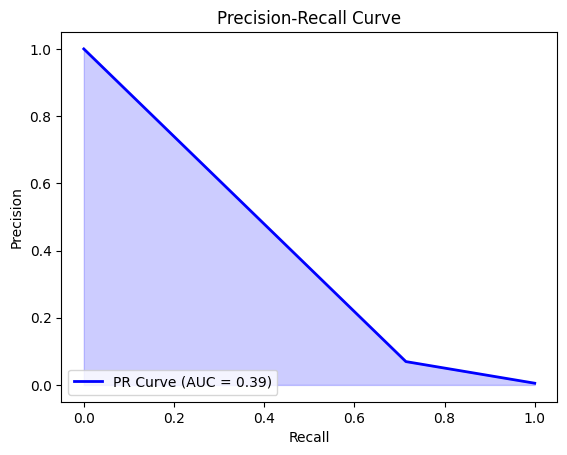

Accuracy: 0.95
Confusion Matrix:
[[1306   67]
 [   2    5]]


In [9]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
precision, recall, _ = precision_recall_curve(labels, det_labels)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR Curve (AUC = %0.2f)' % pr_auc)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

accuracy = accuracy_score(labels, det_labels)
print("Accuracy:", accuracy)
conf_matrix = confusion_matrix(labels, det_labels)
print("Confusion Matrix:")
print(conf_matrix)

NGC OF Scene change detection

In [10]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model = model.to(device)
model.eval()

def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image).unsqueeze(0).to(device)

def detect_scene_change(image1, image2):
    with torch.no_grad():
        input1 = preprocess_image(image1)
        input2 = preprocess_image(image2)

        output1 = model(input1)['out']
        output2 = model(input2)['out']

        output1 = output1.squeeze().cpu().numpy()
        output2 = output2.squeeze().cpu().numpy()

        change_score = np.mean(np.abs(output1 - output2))
        return change_score
    
def extract_number(text):
    match = re.search(r'\d+', text)
    if match:
        return int(match.group())
    else:
        return None

image_folder = "ngc_out"
image_files = os.listdir(image_folder)
image_files.sort()  
scores = []
label_list = []
for i in range(0, len(image_files)-20, 20):  
    image_1_path = os.path.join(image_folder, image_files[i])
    image_2_path = os.path.join(image_folder, image_files[i+20])

    try:
        image_1 = Image.open(image_1_path).convert("RGB")
    except:
        print(f'{image_1_path} Open Error! Skipping to next image.')
        continue

    try:
        image_2 = Image.open(image_2_path).convert("RGB")
    except:
        print(f'{image_2_path} Open Error! Skipping to next image.')
        continue

    
    score = detect_scene_change(image_1, image_2)
    if score > 0.7:
        print(f'Scene change detected between {image_1_path} and {image_2_path}: {score}')
        single_score_list=[]
        image_list=[]
        for j in range(i, i + 21):
            image_1_path = os.path.join(image_folder, image_files[j])
            image_2_path = os.path.join(image_folder, image_files[j+1])

            try:
                image_1 = Image.open(image_1_path).convert("RGB")
            except:
                print(f'{image_1_path} Open Error! Skipping to next image.')
                continue

            try:
                image_2 = Image.open(image_2_path).convert("RGB")
            except:
                print(f'{image_2_path} Open Error! Skipping to next image.')
                continue
            single_score = detect_scene_change(image_1, image_2)
            image_list.append([image_1_path,image_2_path])
            single_score_list.append(single_score)

        indices = [j for j, value in enumerate(single_score_list) if value > 0.7]

        result_score = [single_score_list[index] for index in indices]
        result_image = [image_list[index] for index in indices]
        if len(result_image)==1:
            print(f'Scene change detected between {result_image[0][0]} and {result_image[0][1]}: {result_score[0]}')
            match = int(re.search(r'\d+', result_image[0][1].split('\\')[-1]).group())
            label_list.append(match)
        elif len(result_image)>1:
            for ind,ss in enumerate(result_score):
                if ss > 1:
                    print(f'Scene change detected between {result_image[ind][0]} and {result_image[ind][1]}: {ss}')
                    match = int(re.search(r'\d+', result_image[ind][1].split('\\')[-1]).group())
                    label_list.append(match)
        elif len(result_image)==0 and score <0.9:
            print(f'Scene change detected between {image_list[0][0]} to {image_list[-1][1]}: {score}')
            match1 = int(re.search(r'\d+', image_list[0][0].split('\\')[-1]).group())
            match2 = int(re.search(r'\d+', image_list[-1][1].split('\\')[-1]).group())
            label_list.append(str(match1)+"~"+str(match2))

Scene change detected between ngc_out\ngc-0120.jpeg and ngc_out\ngc-0140.jpeg: 0.9737986326217651
Scene change detected between ngc_out\ngc-0126.jpeg and ngc_out\ngc-0127.jpeg: 0.7562788128852844
Scene change detected between ngc_out\ngc-0140.jpeg and ngc_out\ngc-0160.jpeg: 0.8155036568641663
Scene change detected between ngc_out\ngc-0140.jpeg to ngc_out\ngc-0161.jpeg: 0.8155036568641663
Scene change detected between ngc_out\ngc-0200.jpeg and ngc_out\ngc-0220.jpeg: 1.3259851932525635
Scene change detected between ngc_out\ngc-0220.jpeg and ngc_out\ngc-0240.jpeg: 1.3692803382873535
Scene change detected between ngc_out\ngc-0280.jpeg and ngc_out\ngc-0300.jpeg: 1.3881089687347412
Scene change detected between ngc_out\ngc-0284.jpeg and ngc_out\ngc-0285.jpeg: 1.2870213985443115
Scene change detected between ngc_out\ngc-0320.jpeg and ngc_out\ngc-0340.jpeg: 1.319387435913086
Scene change detected between ngc_out\ngc-0339.jpeg and ngc_out\ngc-0340.jpeg: 1.239985466003418
Scene change detected b

In [11]:
shot_boundaries = []
for line in label_list:
    line = str(line)
    if '~' in line:
        start, end = map(int, line.split('~'))
        shot_boundaries.extend(list(range(start, end+1)))
    else:
        shot_boundaries.append(int(line))

num_frames = len(os.listdir(image_folder))  
det_labels = [0] * num_frames
for frame_index in shot_boundaries:
    det_labels[frame_index - 1] = 1  

print(len(det_labels))

1060


In [12]:
import os

shot_boundaries = []
with open('ngc_ground.txt', 'r') as f:
    for _ in range(4):
        next(f)
    for line in f:
        line = line.strip()
        if '~' in line:
            start, end = map(int, line.split('~'))
            shot_boundaries.extend(list(range(start, end+1)))
        else:
            shot_boundaries.append(int(line))

num_frames = len(os.listdir(image_folder)) 
labels = [0] * num_frames
for frame_index in shot_boundaries:
    labels[frame_index - 1] = 1  

print(len(labels))


1060


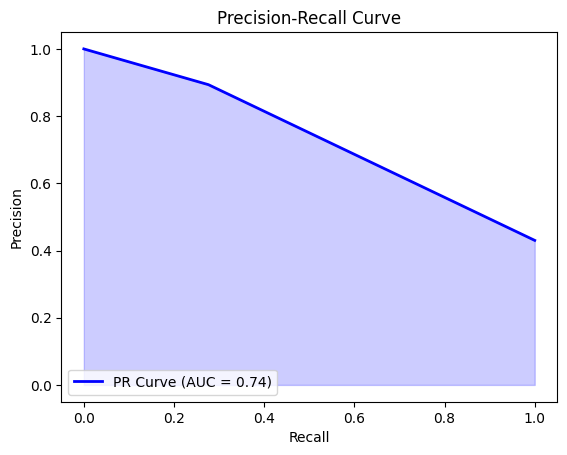

Accuracy: 0.6745283018867925
Confusion Matrix:
[[589  15]
 [330 126]]


In [13]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
precision, recall, _ = precision_recall_curve(labels, det_labels)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR Curve (AUC = %0.2f)' % pr_auc)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

accuracy = accuracy_score(labels, det_labels)
print("Accuracy:", accuracy)
conf_matrix = confusion_matrix(labels, det_labels)
print("Confusion Matrix:")
print(conf_matrix)